# Deep Learning Project Work

# Installing Dependencies

In [1]:
!pip install pyunpack
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 4.0 MB/s eta 0:00:00


# Some Usefull Imports

In [216]:
import os

import numpy as np
from numpy import ndarray
import pandas as pd
import random

import librosa

from IPython.display import Audio

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from tqdm import tqdm


from pyunpack import Archive
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Resizing
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

tqdm.pandas()

%matplotlib inline

# Setting environment

In [41]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Dowloading Data

In [3]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

--2025-03-13 09:53:47--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.127.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  41.8MB/s    in 36s     

2025-03-13 09:54:23 (39.9 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [4]:
!tar -xvzf speech_commands_v0.01.tar.gz

Output streaming troncato alle ultime 5000 righe.
./up/6f9088d7_nohash_0.wav
./up/6f342826_nohash_0.wav
./up/e0a7c5a0_nohash_0.wav
./up/4d4e17f5_nohash_1.wav
./up/b0f24c9b_nohash_0.wav
./up/735845ab_nohash_2.wav
./up/53d5b86f_nohash_0.wav
./up/1a5b9ca4_nohash_1.wav
./up/23abe1c9_nohash_2.wav
./up/bdee441c_nohash_1.wav
./up/a1cff772_nohash_1.wav
./up/1ecfb537_nohash_3.wav
./up/37fc5d97_nohash_3.wav
./up/bd8412df_nohash_1.wav
./up/e53139ad_nohash_1.wav
./up/10ace7eb_nohash_3.wav
./up/30065f33_nohash_0.wav
./up/eefd26f3_nohash_0.wav
./up/c9b653a0_nohash_2.wav
./up/02746d24_nohash_0.wav
./up/e1469561_nohash_0.wav
./up/4bba14ce_nohash_0.wav
./up/b5d1e505_nohash_1.wav
./up/531a5b8a_nohash_1.wav
./up/0135f3f2_nohash_0.wav
./up/dbb40d24_nohash_4.wav
./up/e9287461_nohash_1.wav
./up/71e6ab20_nohash_0.wav
./up/ead2934a_nohash_1.wav
./up/f9af0887_nohash_0.wav
./up/ff63ab0b_nohash_0.wav
./up/f3d06008_nohash_0.wav
./up/918a2473_nohash_4.wav
./up/e54a0f16_nohash_0.wav
./up/cb8f8307_nohash_1.wav
./up/

# Creating train, validation and test dataframes

In [17]:
def create_datasets(base_path, class_list):
    """
    Create train, validation, and test DataFrames from the given base path and class list.
    """
    # Percorsi dei file di testo
    validation_file = os.path.join(base_path, 'validation_list.txt')
    test_file = os.path.join(base_path, 'testing_list.txt')

    # Lettura dei file di testo
    with open(validation_file, 'r') as f:
        validation_paths = f.read().splitlines()

    with open(test_file, 'r') as f:
        test_paths = f.read().splitlines()

    # Creazione di un set per i percorsi di validazione e test
    validation_set = set(validation_paths)
    test_set = set(test_paths)

    # Inizializzazione delle liste per i DataFrame
    train_data = []
    validation_data = []
    test_data = []

    # Iterazione attraverso le classi fornite
    for class_name in class_list:
        class_path = os.path.join(base_path, class_name)

        # Verifica se è una cartella
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                # Costruzione del percorso del file
                file_path = f"{class_name}/{filename}"

                # Controllo se il file è nel set di validazione o test
                if file_path in validation_set:
                    validation_data.append({'filename': filename, 'path': file_path, 'class': class_name})
                elif file_path in test_set:
                    test_data.append({'filename': filename, 'path': file_path, 'class': class_name})
                else:
                    train_data.append({'filename': filename, 'path': file_path, 'class': class_name})

    # Creazione dei DataFrame
    train_df = pd.DataFrame(train_data)
    validation_df = pd.DataFrame(validation_data)
    test_df = pd.DataFrame(test_data)

    return train_df, validation_df, test_df

In [7]:
base_path = '/content'
class_list = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
train_df, validation_df, test_df = create_datasets(base_path, class_list)

In [92]:
num_classes = len(class_list)

In [93]:
print(f"In total we have a classification task with {num_classes} classes.")

In total we have a classification task with 30 classes.


In [16]:
def get_duration(filepath: str) -> float:
    """
    Get the duration of an audio file.

    Args:
        filepath (str): The path to the audio file.

    Returns:
        float: The duration of the audio file in seconds.
    """
    samples, sample_rate = librosa.load(filepath, sr=None)
    duration = librosa.get_duration(y=samples, sr=sample_rate)
    return duration

In [15]:
train_df["duration"] = train_df["path"].progress_apply(lambda x: get_duration(x))
validation_df["duration"] = validation_df["path"].progress_apply(lambda x: get_duration(x))
test_df["duration"] = test_df["path"].progress_apply(lambda x: get_duration(x))

100%|██████████| 6835/6835 [00:01<00:00, 4698.67it/s]


# Inspecting our data

In [24]:
train_df.head()

,filename,path,class,duration
0,953fe1ad_nohash_0.wav,bed/953fe1ad_nohash_0.wav,bed,1.000000
1,161fcca8_nohash_0.wav,bed/161fcca8_nohash_0.wav,bed,0.882375
2,21cbe292_nohash_0.wav,bed/21cbe292_nohash_0.wav,bed,1.000000
3,b1df80c0_nohash_0.wav,bed/b1df80c0_nohash_0.wav,bed,1.000000
4,97e0c576_nohash_3.wav,bed/97e0c576_nohash_3.wav,bed,1.000000


In [25]:
train_df.describe()

,duration
count,51088.000000
mean,0.984141
std,0.060123
min,0.371563
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [88]:
def plot_class_histograms(train_df, validation_df, test_df):
    # Lista dei DataFrame
    dataframes = [train_df, validation_df, test_df]
    titoli = ['Classes in train set', 'Classes in validation set', 'Classes in test set']

    # Creare un istogramma per ogni DataFrame
    for i, df in enumerate(dataframes):
        plt.figure(figsize=(18, 2))
        df['class'].value_counts().plot(kind='bar', color='blue')

        # Aggiungere titolo e etichette
        plt.title(titoli[i], fontsize=16, color='red')
        plt.xlabel('Classes', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=0)

        # Mostrare l'istogramma
        plt.show()

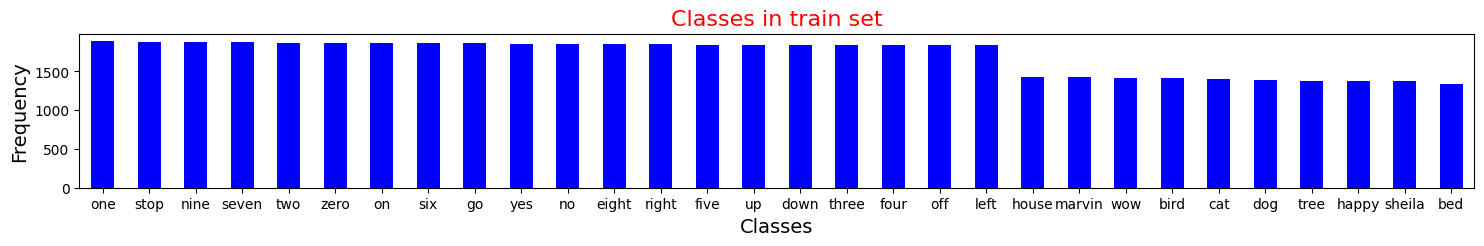

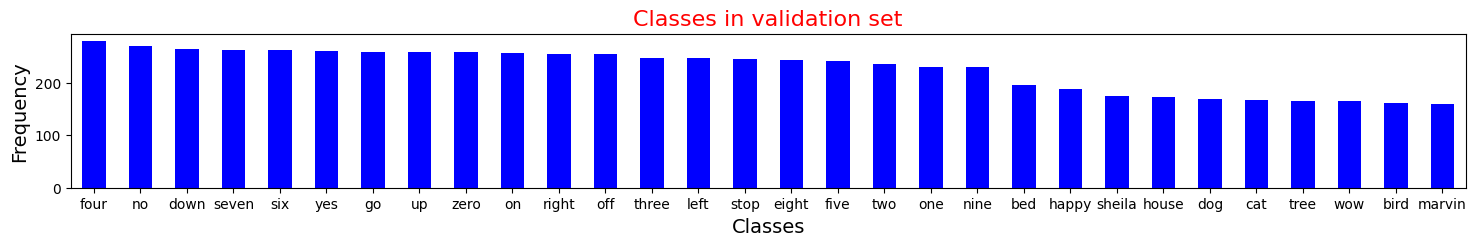

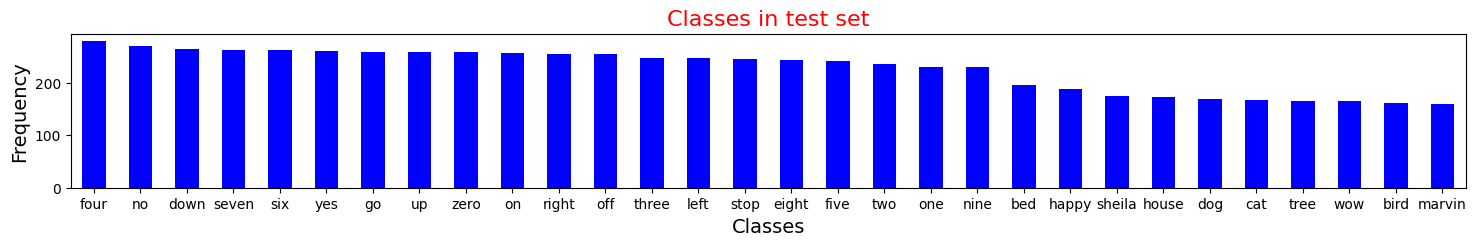

In [89]:
plot_class_histograms(train_df, validation_df, test_df)

As we can see the datasets are pretty balanced.

In [21]:
def plot_duration_histograms(train_df, validation_df, test_df):
    # Creazione della figura e degli assi
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Istogramma per il primo DataFrame
    axs[0].hist(train_df['duration'], bins=30, color='blue', alpha=0.7)
    axs[0].set_title('Durations in train set')
    axs[0].set_xlabel('Duration')
    axs[0].set_ylabel('Frequency')

    # Istogramma per il secondo DataFrame
    axs[1].hist(validation_df['duration'], bins=30, color='green', alpha=0.7)
    axs[1].set_title('Durations in validation set')
    axs[1].set_xlabel('Duration')
    axs[1].set_ylabel('Frequency')

    # Istogramma per il terzo DataFrame
    axs[2].hist(test_df['duration'], bins=30, color='red', alpha=0.7)
    axs[2].set_title('Durations test set')
    axs[2].set_xlabel('Duration')
    axs[2].set_ylabel('Frequency')

    # Aggiunta di un titolo generale
    plt.suptitle('Histogram of Durations in the dataset', color='red')

    # Mostra la figura
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Aggiusta il layout
    plt.show()

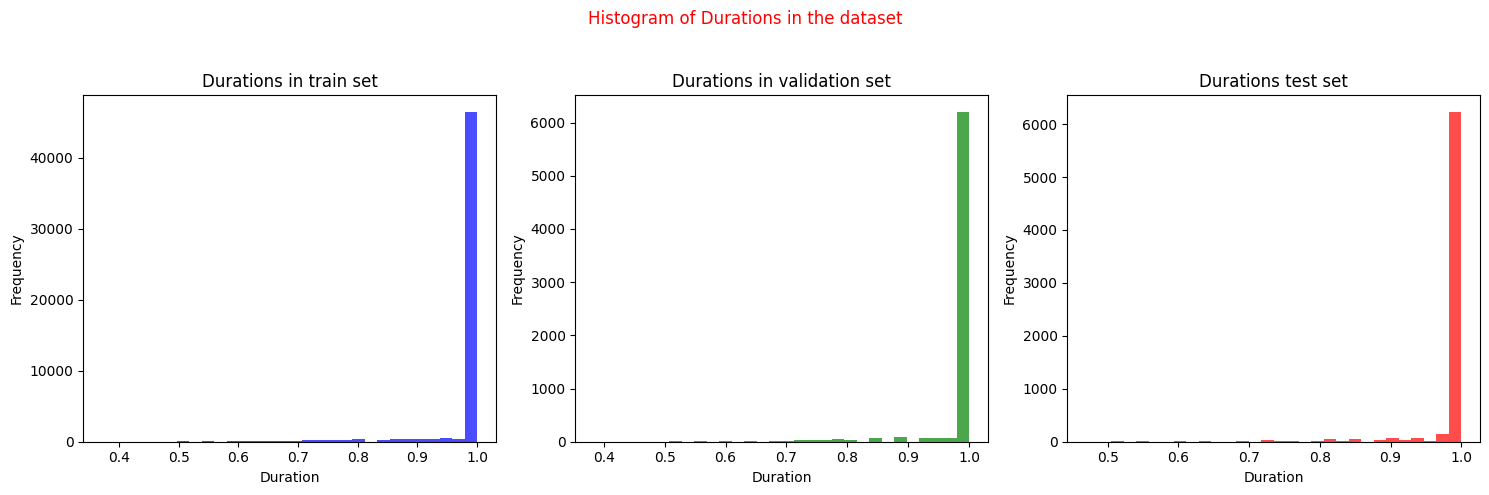

In [22]:
plot_duration_histograms(train_df, validation_df, test_df)

As we can see some audio don't have the duration of 1 second. So, it is clear that we need to zero pad them in order to have similar MFCC to give as input to our model.

In [48]:
def play_random_audio_and_plot_waveform_mfcc_stft(df):
    """
    Select a random audio from the DataFrame, play it,
    and plot the waveform, MFCC spectrogram, and STFT spectrogram.
    """
    # Seleziona un percorso casuale dalla colonna 'path'
    random_index = random.choice(df.index)
    audio_path = df.loc[random_index, 'path']

    # Carica l'audio con librosa
    audio_data, sample_rate = librosa.load(audio_path)

    # Riproduci l'audio
    display(Audio(audio_path, rate=sample_rate))

    # Stampa la waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sample_rate, color='blue')
    plt.title(f'Waveform of audio: {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    # Calcola e stampa lo spettrogramma MFCC
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='coolwarm')
    plt.title(f'MFCC Spectrogram of audio: {audio_path}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')
    plt.grid()
    plt.show()

    # Calcola e stampa lo spettrogramma STFT
    D = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.title(f'STFT Spectrogram of audio: {audio_path}')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()
    plt.show()

    # Restituisce il percorso audio scelto
    return audio_path

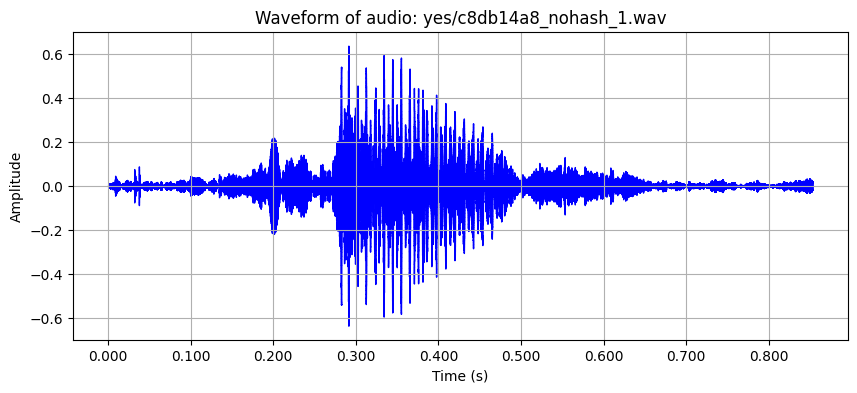

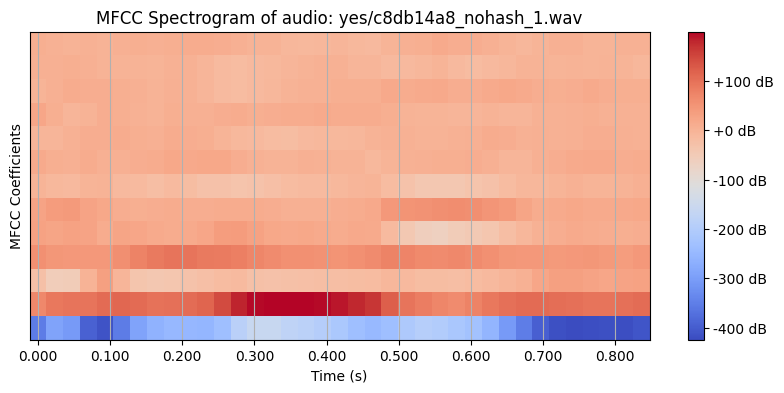

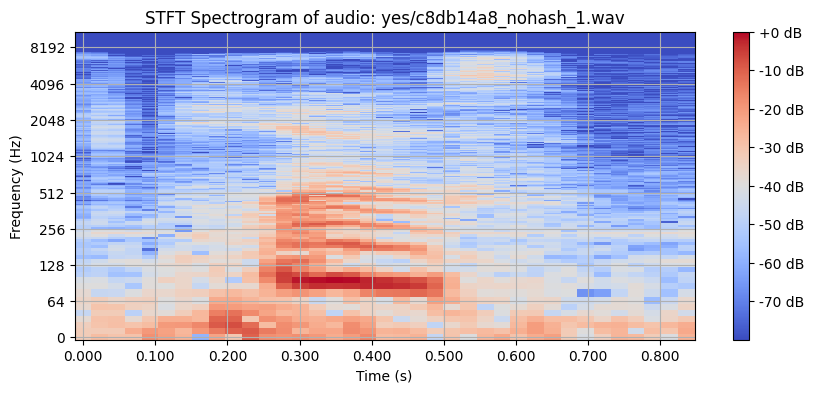

In [49]:
casual_audio_path = play_random_audio_and_plot_waveform_mfcc_stft(train_df)

# Features Extraction and Engineering

Not all our audio present a duration equal to 1.0 second. So, we need to zero-pad their waveforms in order to have Spectrograms with similar dimensions.

Also, the spectrograms are 2D arrays, thus, we can use them as input to a convolutional model in order to perform audio classification.

In [61]:
def add_waveform_column(df, target_duration, sample_rate = 16000):
    """
    Aggiunge una colonna 'waveform' al DataFrame contenente le waveforms degli audio.
    Le waveforms vengono zero-paddate per avere una durata uguale a 'target_duration'.

    Parameters:
    - df: DataFrame contenente i percorsi audio nella colonna 'path'.
    - target_duration: Durata target in secondi per le waveforms.
    - sample_rate: Frequenza di campionamento dell'audio (default è 16000).

    Returns:
    - df: DataFrame aggiornato con la colonna 'waveform'.
    """

    # Calcola il numero di campioni per la durata target
    target_samples = int(target_duration * sample_rate)

    # Aggiunge la colonna 'waveform'
    waveforms = []

    for index, row in df.iterrows():
        audio_path = row['path']

        # Carica l'audio
        audio_data, sr = librosa.load(audio_path, sr=sample_rate)

        # Zero-padding se necessario
        if len(audio_data) < target_samples:
            # Aggiungi zero-padding
            padded_waveform = np.pad(audio_data, (0, target_samples - len(audio_data)), mode='constant')
        else:
            # Trunca l'audio se è più lungo della durata target
            padded_waveform = audio_data[:target_samples]

        waveforms.append(padded_waveform)

    # Aggiungi la lista delle waveforms come nuova colonna
    df['waveform'] = waveforms

    return df

In [62]:
sample_rate = 16000
train_df = add_waveform_column(train_df, target_duration=1.0, sample_rate = sample_rate)
validation_df = add_waveform_column(validation_df, target_duration=1.0, sample_rate = sample_rate)
test_df = add_waveform_column(test_df, target_duration=1.0, sample_rate = sample_rate)

In [63]:
def add_mfcc_column(df, sample_rate = 16000):
    """
    Aggiunge una colonna 'mfcc' al DataFrame contenente i coefficienti MFCC delle waveforms.

    Parameters:
    - df: DataFrame contenente le waveforms nella colonna 'waveform'.
    - n_mfcc: Numero di coefficienti MFCC da calcolare (default è 13).

    Returns:
    - df: DataFrame aggiornato con la colonna 'mfcc'.
    """
    mfccs_list = []

    for index, row in df.iterrows():
        waveform = row['waveform']

        # Calcola i coefficienti MFCC
        mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate)

        # Aggiungi i MFCC alla lista
        mfccs_list.append(mfccs)

    # Aggiungi la lista dei MFCC come nuova colonna
    df['mfcc'] = mfccs_list

    return df

In [64]:
train_df = add_mfcc_column(train_df, sample_rate = sample_rate)
validation_df = add_mfcc_column(validation_df, sample_rate = sample_rate)
test_df = add_mfcc_column(validation_df, sample_rate = sample_rate)

In [78]:
print("Number of elements in train dataframe:", len(train_df))
print("Number of elements in validation dataframe:", len(validation_df))
print("Number of elements in test dataframe:", len(test_df))

Number of elements in train dataframe: 51088
Number of elements in validation dataframe: 6798
Number of elements in test dataframe: 6798


# Input Data Creation

In [217]:
def create_tf_dataset(df):
    """
    Crea un dataset TensorFlow a partire da un DataFrame.

    Parameters:
    - df: DataFrame contenente le colonne 'mfcc' e 'class'.

    Returns:
    - dataset: Dataset TensorFlow contenente i dati e le etichette.
    """

    # Estrai i dati e le etichette
    mfccs = df['mfcc'].tolist()
    labels = df['class'].tolist()

    # Converti le etichette stringa in numeri
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Converti le etichette in one-hot encoding
    labels_one_hot = to_categorical(labels_encoded, num_classes=30)

    # Crea il dataset TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((mfccs, labels_one_hot))

    return dataset

In [218]:
train_ds = create_tf_dataset(train_df).shuffle(buffer_size = 10000)
validation_ds = create_tf_dataset(validation_df).shuffle(buffer_size = 10000)
test_ds = create_tf_dataset(test_df).shuffle(buffer_size = 10000)

In [219]:
def add_channel_dimension(mfcc, label):
    mfcc_with_channel = tf.expand_dims(mfcc, axis=-1)
    return mfcc_with_channel, label

In [220]:
train_ds = train_ds.map(add_channel_dimension)
validation_ds = validation_ds.map(add_channel_dimension)
test_ds = test_ds.map(add_channel_dimension)

In [221]:
count = train_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in train dataset:", count)
count = validation_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in validation dataset:", count)
count = test_ds.reduce(0, lambda x, _: x + 1).numpy()
print("Number of elements in test dataset:", count)

Number of elements in train dataset: 51088
Number of elements in validation dataset: 6798
Number of elements in test dataset: 6798


# Model Creation

In [222]:
NUM_CLASSES = len(class_list)
input_shape = train_ds.element_spec[0].shape
batch_size = 32

In [223]:
train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [224]:
input_shape

TensorShape([20, 32, 1])

In [234]:
model1 = Sequential([
    Input(shape=input_shape),
    Conv2D(16, 3,  activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax'),
])

In [235]:
model1.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 18, 30, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 9, 15, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 2160)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 100)                 │         216,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 30)                  │           3,030 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,290 (856.60 KB)

 Trainable params: 219,290 (856.60 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', 'f1_score'],
)

In [237]:
EPOCHS = 10
history1 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = EPOCHS
)

Epoch 1/10
2555/2555 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.2614 - f1_score: 0.1324 - loss: 3.7666 - val_accuracy: 0.0387 - val_f1_score: 0.0027 - val_loss: 3.4090
Epoch 2/10
2555/2555 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.2182 - f1_score: 0.1262 - loss: 2.5572 - val_accuracy: 0.0775 - val_f1_score: 0.0226 - val_loss: 3.5606
Epoch 3/10
2555/2555 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.1607 - f1_score: 0.0965 - loss: 2.6668 - val_accuracy: 0.1034 - val_f1_score: 0.0405 - val_loss: 3.5509
Epoch 4/10
2555/2555 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3285 - f1_score: 0.2173 - loss: 2.1373 - val_accuracy: 0.1365 - val_f1_score: 0.0602 - val_loss: 3.2321
Epoch 5/10
2555/2555 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4198 - f1_score: 0.2939 - loss: 1.8671 - val_accuracy: 0.1827 - val_f1_score: 0.1196 - val_loss: 3.0206
Epoch 6/10
2555/2555 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.4640 - f1_score: 0.3175 - loss: 1.6916 - val_accuracy: 0.1692 - va